<a href="https://colab.research.google.com/github/KSR313/Ml_TimeSeries/blob/main/ML_TimeSeries_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[link text](https://builtin.com/data-science/time-series-forecasting-python)

# **A Guide to Time Series Forecasting in Python:**

## Initialization


###  Import the dependencies

In [ ]:
# to read finance data
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

# to work with data
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# to show a chart of data
import matplotlib.pyplot as plt
import seaborn as sns

# to convert date
import datetime


### Import Data


In [ ]:
# fetch data
btc_data = pdr.get_data_yahoo(['BTC-USD'],
                          start=datetime.datetime(2020, 2, 2),
                          end=datetime.datetime(2023, 4, 4))['Close']

# convert to csv
btc_data.to_csv("btc.csv")
btc = pd.read_csv("btc.csv")

# indexing by day
btc.index = pd.to_datetime(btc['Date'], format='%Y-%m-%d')

# cleanup
del btc['Date']
print(btc.head())

[*********************100%%**********************]  1 of 1 completed
                  Close
Date                   
2020-02-02  9344.365234
2020-02-03  9293.521484
2020-02-04  9180.962891
2020-02-05  9613.423828
2020-02-06  9729.801758


##Splitting Data

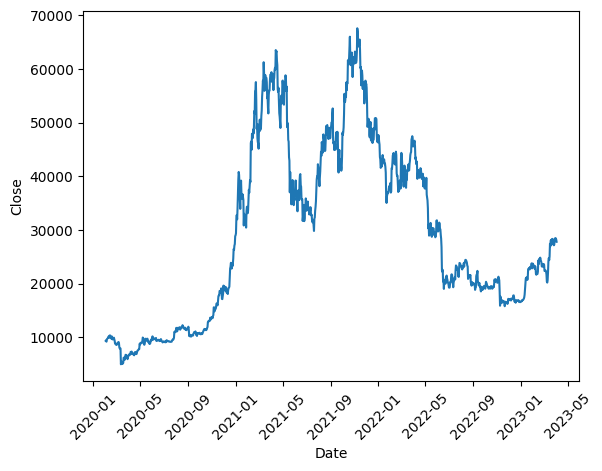

In [ ]:
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc, )

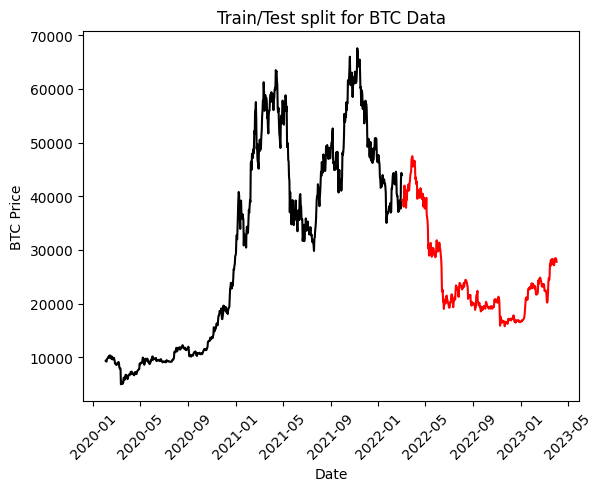

In [ ]:
pivot_date = "2022-03-03"
train = btc[btc.index < pd.to_datetime(pivot_date, format='%Y-%m-%d')]
test = btc[btc.index > pd.to_datetime(pivot_date, format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

# Seasonal ARIMA (SARIMA)

In [ ]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order = (2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

#  ONLINE Seasonal ARIMA (SNARIMA)

##SNARIMAX stands for (S)easonal (N)on-linear (A)uto(R)egressive (I)ntegrated (M)oving-(A)verage with e(X)ogenous inputs model.


In [ ]:
!pip install river

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime as dt
from river import time_series
from river import utils

In [ ]:
import datetime as dt
from river import datasets
from river import time_series
from river import utils

period = 12
model = time_series.SNARIMAX(
    p=period,
    d=1,
    q=period,
    m=period,
    sd=1
)

for y in train:
    model.learn_one(y)

horizon = 11
future = [
    {'month': dt.date(year=2023, month=m, day=1)}
    for m in range(1, horizon + 1)
]
print(type(future))
forecast = model.forecast(horizon=horizon)
for x, y_pred in zip(future, forecast):
    print(x['month'], f'{y_pred:.3f}')



<class 'list'>
2023-01-01 0.000
2023-02-01 0.000
2023-03-01 0.000
2023-04-01 0.000
2023-05-01 0.000
2023-06-01 0.000
2023-07-01 0.000
2023-08-01 0.000
2023-09-01 0.000
2023-10-01 0.000
2023-11-01 0.000


In [ ]:
import datetime as dt
from river import datasets
from river import time_series
from river import utils

period = 12
model = time_series.SNARIMAX(
    p=period,
    d=1,
    q=period,
    m=period,
    sd=1
)

for t, (x, y) in enumerate(datasets.AirlinePassengers()):
    model.learn_one(y)

horizon = 12
future = [
    {'month': dt.date(year=1961, month=m, day=1)}
    for m in range(1, horizon + 1)
]
forecast = model.forecast(horizon=horizon)
for x, y_pred in zip(future, forecast):
    print(x['month'], f'{y_pred:.3f}')



1961-01-01 494.542
1961-02-01 450.825
1961-03-01 484.972
1961-04-01 576.401
1961-05-01 559.489
1961-06-01 612.251
1961-07-01 722.410
1961-08-01 674.604
1961-09-01 575.716
1961-10-01 562.808
1961-11-01 477.049
1961-12-01 515.191


In [ ]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing

def get_month_distances(x):
    return {
        calendar.month_name[month]: math.exp(-(x['month'].month - month) ** 2)
        for month in range(1, 13)
    }

def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}

extract_features = compose.TransformerUnion(
    get_ordinal_date,
    get_month_distances
)

model = (
    extract_features |
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=0,
        m=12,
        sp=3,
        sq=6,
        regressor=(
            preprocessing.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110,
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
    )
)

for x, y in datasets.AirlinePassengers():
    model.learn_one(x, y)

forecast = model.forecast(horizon=horizon)
for x, y_pred in zip(future, forecast):
    print(x['month'], f'{y_pred:.3f}')

1961-01-01 444.821
1961-02-01 432.612
1961-03-01 457.739
1961-04-01 465.544
1961-05-01 476.575
1961-06-01 516.255
1961-07-01 565.405
1961-08-01 572.470
1961-09-01 512.645
1961-10-01 475.919
1961-11-01 438.033
1961-12-01 456.892
